# LangGraph
------------
### LangGraph can help you create multiagent workflow.

## Key Features:
> ### 1. Cycles and Branching: Conditional statements and loops
> ### 2. Easily integrate it with the Langchain
> ### 3. You can have human in the loop also.

In [1]:
!pip install -U langchain langgraph langsmith langchain-fireworks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.9/109.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.2/325.2 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## Setting up the APIs

In [2]:
import getpass
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass()

··········


In [3]:
os.environ['FIREWORKS_API_KEY'] = getpass.getpass()

··········


# Basic Chatbot

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

```
name = Annotated[str, "first letter is capital"]
```

## Now our graph knows two things:
> ### 1. Every node will recieve the current state as inuput and return a value that updates that state
> ### 2. Messages will be appended to the current list, rather than directly overwritten.

## Let's define a node (chatbot node). Nodes represent the working unit. It is going to be a simple Python fucntion

In [5]:
from langchain_fireworks import ChatFireworks

llm = ChatFireworks(model='accounts/fireworks/models/llama-v3p1-8b-instruct')


def chatbot(state: State):
  return {'messages': [llm.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

### Creating an entry point

In [7]:
graph_builder.add_edge('chatbot', END)

### Creating an endpoint

In [6]:
graph_builder.add_edge(START, 'chatbot')

### Now we would like to run our graph, for that we will compile it.

In [8]:
graph = graph_builder.compile()

Let's visualize our graph

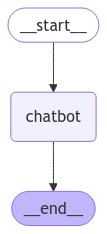

In [9]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

### Let's run our chatbot

In [12]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
      print("Assistant:", value["messages"][-1].content)

while True:
  user_input = input("User: ")
  if user_input.lower() in ['quit', 'exit', 'q']:
    print("Goodbye!")
    break
  stream_graph_updates(user_input)

User: Hi, tell me about Ratan Tata
Assistant: Ratan Tata is a renowned Indian business magnate, philanthropist, and former chairman of the Tata Group, one of India's largest and most respected conglomerates. Here's a brief overview of his life and achievements:

**Early Life and Education**

Ratan Naval Tata was born on December 28, 1937, in Surat, Gujarat, India. He is the second son of Naval Tata, a member of the Tata family, who was a successful businessman and a member of the Tata Group. Ratan Tata's great-grandfather, Jamsetji Tata, founded the Tata Group in 1868.

Ratan Tata received his education at the Cathedral and John Connon School in Mumbai and later at the Cornell University in the United States, where he earned a degree in architecture.

**Career**

Ratan Tata joined the Tata Group in 1962 and worked in various roles, including as a management trainee, a production manager, and a marketing manager. In 1991, he became the chairman of Tata Sons, the holding company of the T

# Enhancing the Chatbot with Tools
----------------------------------
### We will integrate a web serach tool. Out bot can use this tool to find the relevant information

In [13]:
%pip install -qU duckduckgo-search langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00


In [18]:
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults

wrapper = DuckDuckGoSearchAPIWrapper(max_results=2)

search = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")

search.invoke("Ratan Tata")

'snippet: Ratan Tata, who has died aged 86, was one of India\'s most internationally recognised business leaders. The tycoon led the Tata Group - known as a "salt-to-software" conglomerate of more than 100 ..., title: Ratan Tata: The \'modest\' Indian tycoon who died at 86 - BBC, link: https://www.bbc.com/news/articles/cd11lz4vpr7o, snippet: Ratan Tata, the businessman who inherited one of India\'s oldest conglomerates and transformed it through a string of eye-catching deals into a global empire, has died. He was 86., title: Ratan Tata, Who Grew India\'s Tata Group Into Global Empire, Dies at 86 ..., link: https://www.bloomberg.com/news/articles/2024-10-09/ratan-tata-patriarch-of-biggest-indian-conglomerate-dies-at-86, snippet: Ratan Tata, who was one of India\'s best known businesspeople and led his family conglomerate on a bold international expansion, has died aged 86., title: Ratan Tata, leading Indian businessman, 1937-2024 - Financial Times, link: https://www.ft.com/content/5a40

### integrate this search tool with our chatbot

In [26]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_fireworks import ChatFireworks

from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode, tools_condition

# State Graph
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# My Search Tool
wrapper = DuckDuckGoSearchAPIWrapper(max_results=2)

tool = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")
tools = [tool]

# Chatbot node
llm = ChatFireworks(model='accounts/fireworks/models/llama-v3p1-8b-instruct')
llm_with_tool = llm.bind_tools(tools)

def chatbot(state: State):
  return {'messages': [llm_with_tool.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

# Tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

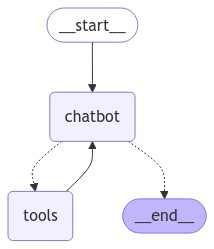

In [27]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [28]:
while True:
  user_input = input("User: ")
  if user_input.lower() in ['quit', 'exit', 'q']:
    print("Goodbye!")
    break
  stream_graph_updates(user_input)

User: What's the current time in Delhi?
Assistant: However, I'm a large language model, I don't have real-time access to the current time. But I can suggest a few options to help you find out the current time in Delhi:

1. **Check online world clocks**: You can search for "current time in Delhi" on a search engine like Google, and it will show you the current time in Delhi along with other cities around the world.
2. **Use a world clock website**: Websites like WorldTimeBuddy or TimeAndDate provide a world clock that shows the current time in various cities, including Delhi.
3. **Check your phone or computer**: If you have a smartphone or a computer, you can check the current time in Delhi by searching for "current time in Delhi" or by using a world clock app.

Please note that Delhi is in the Indian Standard Time (IST) zone, which is UTC+5:30.
User: quit
Goodbye!


# Adding memory to the chatbot

In [31]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [32]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_fireworks import ChatFireworks

from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools import DuckDuckGoSearchResults
from langgraph.prebuilt import ToolNode, tools_condition

# State Graph
class State(TypedDict):
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


# My Search Tool
wrapper = DuckDuckGoSearchAPIWrapper(max_results=2)

tool = DuckDuckGoSearchResults(api_wrapper=wrapper, source="news")
tools = [tool]

# Chatbot node
llm = ChatFireworks(model='accounts/fireworks/models/llama-v3p1-8b-instruct')
llm_with_tool = llm.bind_tools(tools)

def chatbot(state: State):
  return {'messages': [llm_with_tool.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

# Tool node
tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")


### Finally, compile the graph with the provided checkpoint

In [34]:
graph = graph_builder.compile(checkpointer=memory)

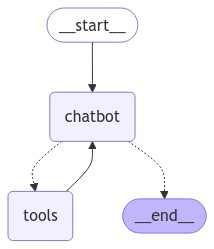

In [35]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
  pass

### Let's pick up a thread to use it as a key for this conversation

In [36]:
config = {'configurable': {'thread_id': "1"}}

In [38]:
user_input = "Hi, there! My name is Amit Arjun."

events = graph.stream(
    {'messages': [("user", user_input)]},
    config,
    stream_mode="values"
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi, there! My name is Amit Arjun.
================================== Ai Message ==================================

Nice to meet you, Amit Arjun! It's great to have you here. Is there something I can help you with or would you like to chat?


### Let's resume this convo with the same id

In [39]:
user_input = "Hi, there! Remenber my name"

events = graph.stream(
    {'messages': [("user", user_input)]},
    config,
    stream_mode="values"
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi, there! Remenber my name
================================== Ai Message ==================================

I remember, your name is Amit Arjun! How can I assist you today, Amit?


In [41]:
user_input = "Hi, there! Remember my name"

events = graph.stream(
    {'messages': [("user", user_input)]},
    {'configurable': {'thread_id': "1"}},
    stream_mode="values"
)
for event in events:
  event['messages'][-1].pretty_print()

================================ Human Message =================================

Hi, there! Remember my name
================================== Ai Message ==================================

I remember, your name is Amit Arjun! I've got it stored in my memory. What's on your mind today, Amit?
